In [2]:
!pip install -q swig
!pip install -q gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 68.6 MB/s eta 0:00:00


In [3]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import base64, io

from collections import deque, namedtuple

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LEARNING_RATE = 5e-4
UPDATE_EVERY = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
env = gym.make('LunarLander-v2')
env.seed(0)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[0]

In [12]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def print_network(self):
        print(self)

In [13]:
network.print_network()

QNetwork(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [6]:
class Agent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = deque(maxlen=BUFFER_SIZE)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.sample_from_memory()
                self.learn(experiences, GAMMA)

    def sample_from_memory(self):
        experiences = random.sample(self.memory, k=BATCH_SIZE)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


In [7]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

In [8]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -164.29
Episode 200	Average Score: -110.87
Episode 300	Average Score: -31.40
Episode 400	Average Score: -11.98
Episode 500	Average Score: 89.80
Episode 600	Average Score: 168.34
Episode 700	Average Score: 182.66
Episode 800	Average Score: 184.12
Episode 900	Average Score: 165.00
Episode 1000	Average Score: 192.16
Episode 1020	Average Score: 200.42
Environment solved in 920 episodes!	Average Score: 200.42


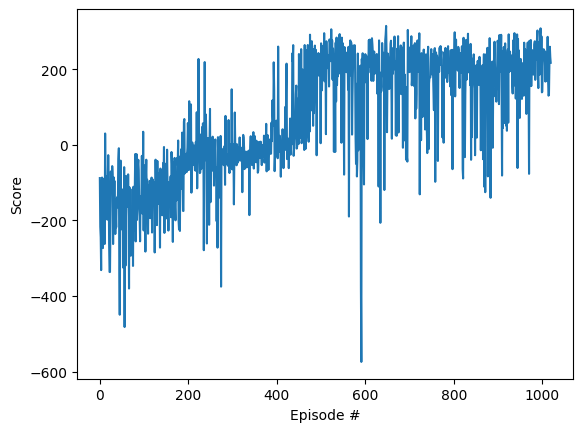

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="/video/{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action = agent.act(state)

        state, reward, done, _ = env.step(action)
    env.close()

In [11]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead